# 프로젝트 : 개선된 U-Net 모델 만들기

In [1]:
#필요한 라이브러리를 로드
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## 데이터 로더 만들기

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행
                Resize(
                    width=224,
                    height=224
                    )
                ])

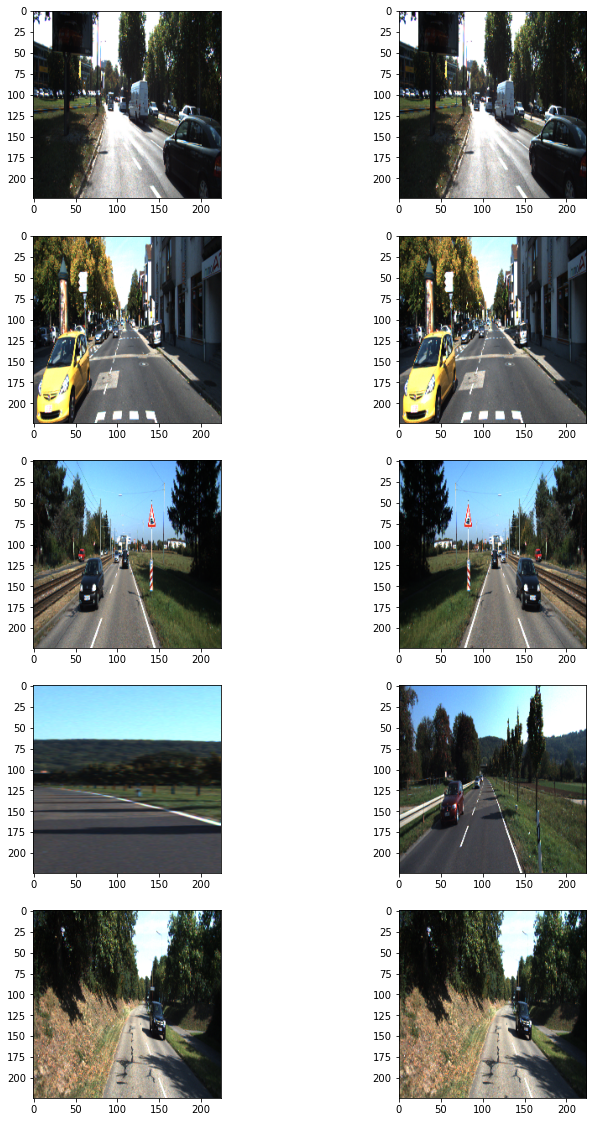

In [3]:
dir_path = './data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용 
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=1,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 모델 설계하기

In [6]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
model = build_model()

In [8]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## 모델 학습하기

In [9]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
170/170 [==============================] - 11s 64ms/step - loss: 0.4635 - val_loss: 0.5516
Epoch 2/100
170/170 [==============================] - 11s 63ms/step - loss: 0.3530 - val_loss: 0.3278
Epoch 3/100
170/170 [==============================] - 11s 63ms/step - loss: 0.2874 - val_loss: 0.3669
Epoch 4/100
170/170 [==============================] - 11s 63ms/step - loss: 0.2789 - val_loss: 0.3074
Epoch 5/100
170/170 [==============================] - 11s 63ms/step - loss: 0.2627 - val_loss: 0.3291
Epoch 6/100
170/170 [==============================] - 11s 63ms/step - loss: 0.2392 - val_loss: 0.2774
Epoch 7/100
170/170 [==============================] - 11s 64ms/step - loss: 0.2671 - val_loss: 0.3263
Epoch 8/100
170/170 [==============================] - 11s 64ms/step - loss: 0.2667 - val_loss: 0.3022
Epoch 9/100
170/170 [==============================] - 11s 64ms/step - loss: 0.2419 - val_loss: 0.32

170/170 [==============================] - 11s 62ms/step - loss: 0.1735 - val_loss: 0.2379
Epoch 76/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1660 - val_loss: 0.2271
Epoch 77/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1583 - val_loss: 0.2657
Epoch 78/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1545 - val_loss: 0.2233
Epoch 79/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1491 - val_loss: 0.2381
Epoch 80/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1566 - val_loss: 0.1842
Epoch 81/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1451 - val_loss: 0.2563
Epoch 82/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1541 - val_loss: 0.2484
Epoch 83/100
170/170 [==============================] - 11s 62ms/step - loss: 0.1705 - val_loss: 0.1912
Epoch 84/100
170/170 [==============================] - 10s 62ms/step - loss:

In [10]:
model_path = dir_path + '/seg_model_unet_batch_1.h5'

In [11]:
model.save(model_path)  #학습한 모델을 저장해 주세요.

In [12]:
model = tf.keras.models.load_model(model_path)

## 모델 시각화

In [13]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    
    return output

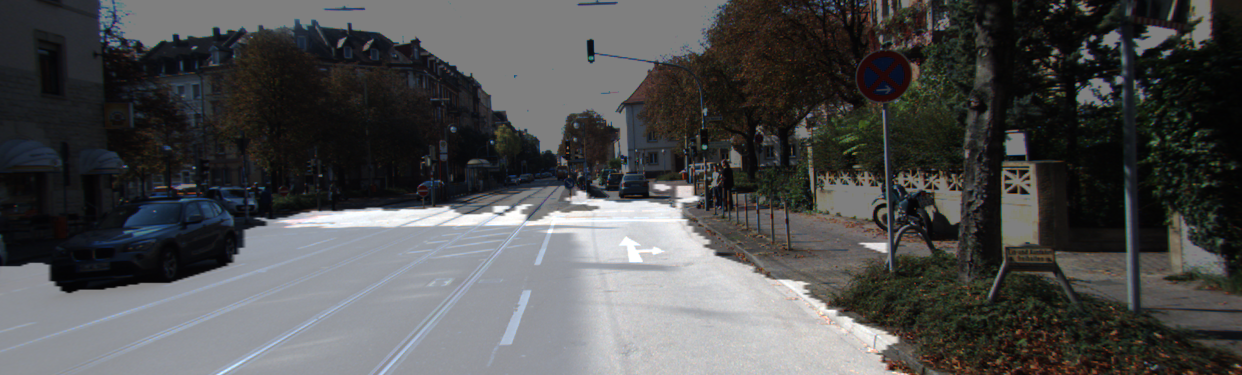

In [14]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 

model = tf.keras.models.load_model(model_path)
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [15]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    
    return iou_score

In [16]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [23]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 3    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.793475


0.7934754687901362

## UNet++ 모델

In [9]:
def build_unet_plus_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    pool_0 = MaxPooling2D((2, 2))(conv0_0)

    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_0)
    conv0_1 = UpSampling2D((2, 2))(conv1_0)
    conv0_1 = tf.concat([conv0_1, conv0_0], axis=3)
    pool_1 = MaxPooling2D((2, 2))(conv1_0)
    
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_1)
    conv1_1 = UpSampling2D((2, 2))(conv2_0)
    conv1_1 = tf.concat([conv1_1, conv1_0], axis=3)
    conv0_2 = UpSampling2D((2, 2))(conv1_1)
    conv0_2 = tf.concat([conv0_2, conv0_1, conv0_0], axis=3)
    pool_2 = MaxPooling2D((2, 2))(conv2_0)
    
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_2)
    conv2_1 = UpSampling2D((2, 2))(conv3_0)
    conv2_1 = tf.concat([conv2_1, conv2_0], axis=3)
    conv1_2 = UpSampling2D((2, 2))(conv2_1)
    conv1_2 = tf.concat([conv1_2, conv1_1, conv1_0], axis=3)
    conv0_3 = UpSampling2D((2, 2))(conv1_2)
    conv0_3 = tf.concat([conv0_3, conv0_2, conv0_0], axis=3)
    pool_3 = MaxPooling2D((2, 2))(conv3_0)
    
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool_3)
    
#     up_3 = UpSampling2D((2, 2))(conv4_0)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D((2, 2))(conv4_0))
    conv3_1 = tf.concat([conv3_1, conv3_0], axis=3)
    
#     up_2 = UpSampling2D((2, 2))(conv3_1)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D((2, 2))(conv3_1))
    conv2_2 = tf.concat([conv2_2, conv2_1, conv2_0], axis=3)
    
#     up_1 = UpSampling2D((2, 2))(conv2_2)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D((2, 2))(conv2_2))
    conv1_3 = tf.concat([conv1_3, conv1_2, conv1_0], axis=3)
    
#     up_0 = UpSampling2D((2, 2))(conv1_3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D((2, 2))(conv1_3))
    conv0_4 = tf.concat([conv0_4, conv0_3, conv0_0], axis=3)

    output = Conv2D(1, 1, activation='sigmoid')(conv0_4)

    model = Model(inputs = inputs, outputs = output)
    return model

In [10]:
unet_model = build_unet_plus_model()

In [11]:
unet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 128 73856       max_pooling2d[0][0]              
_______________________________________________________________________________________

## UNet++ 모델 학습

In [15]:
unet_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100
170/170 [==============================] - 21s 124ms/step - loss: 0.3883 - val_loss: 0.4105
Epoch 2/100
170/170 [==============================] - 20s 119ms/step - loss: 0.2713 - val_loss: 0.2765
Epoch 3/100
170/170 [==============================] - 20s 119ms/step - loss: 0.2267 - val_loss: 0.3039
Epoch 4/100
170/170 [==============================] - 20s 120ms/step - loss: 0.2198 - val_loss: 0.2728
Epoch 5/100
170/170 [==============================] - 20s 120ms/step - loss: 0.2007 - val_loss: 0.2211
Epoch 6/100
170/170 [==============================] - 20s 120ms/step - loss: 0.1868 - val_loss: 0.2357
Epoch 7/100
170/170 [==============================] - 20s 120ms/step - loss: 0.2051 - val_loss: 0.3578
Epoch 8/100
170/170 [==============================] - 20s 120ms/step - loss: 0.1873 - val_loss: 0.3477
Epoch 9/100
170/170 [==============================] - 20s 120ms/step - loss: 0.2018 - val_loss: 0.2470
Epoch 10/100
170/170 [==============================] - 20s 120m

170/170 [==============================] - 20s 119ms/step - loss: 0.0815 - val_loss: 0.1654
Epoch 80/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0902 - val_loss: 0.1745
Epoch 81/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0682 - val_loss: 0.2280
Epoch 82/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0695 - val_loss: 0.1675
Epoch 83/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0842 - val_loss: 0.2348
Epoch 84/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0899 - val_loss: 0.3381
Epoch 85/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0719 - val_loss: 0.1859
Epoch 86/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0733 - val_loss: 0.2125
Epoch 87/100
170/170 [==============================] - 20s 119ms/step - loss: 0.0904 - val_loss: 0.2365
Epoch 88/100
170/170 [==============================] - 20s 119ms/st

In [18]:
unetpp_model_path = dir_path + '/seg_model_unetpp_batch_1.h5'

In [16]:
unet_model.save(unetpp_model_path)  #학습한 모델을 저장해 주세요.

In [19]:
unetpp_model = tf.keras.models.load_model(unetpp_model_path)

## 모델 시각화

In [24]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 3 # i값을 바꾸면 테스트용 파일이 달라집니다. 

output, prediction, target = get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.831023


0.8310233214374637

## 모델 성능 비교

In [27]:
unet_model_path = dir_path + '/seg_model_unet_batch_1.h5'
unetpp_model_path = dir_path + '/seg_model_unetpp_batch_1.h5'

In [28]:
unet_model = tf.keras.models.load_model(unet_model_path)
unetpp_model = tf.keras.models.load_model(unetpp_model_path)

In [50]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
#     output.show()
    
    return output

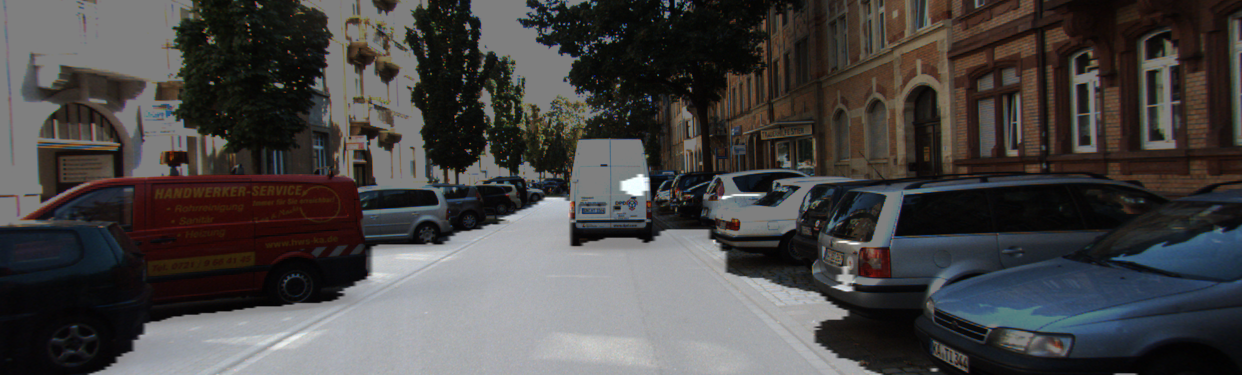

In [61]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 

# U-Net
get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

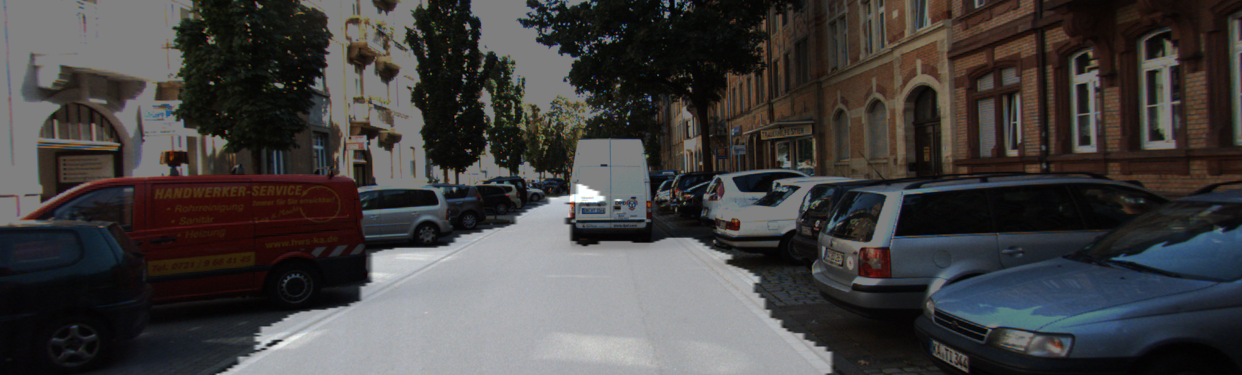

In [62]:
# U-Net++
get_output(
     unetpp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [63]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [29]:
unet_iou = []
unetpp_iou = []
for i in range(10):
    output, prediction, target = get_output(unet_model, 
                                            test_preproc, 
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
                                           )
    unet_iou.append(calculate_iou_score(target, prediction))
    output, prediction, target = get_output(unetpp_model, 
                                            test_preproc, 
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
                                           )
    unetpp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.926338
IoU : 0.946248
IoU : 0.927964
IoU : 0.941404
IoU : 0.777253
IoU : 0.909788
IoU : 0.793475
IoU : 0.831023
IoU : 0.769661
IoU : 0.878222
IoU : 0.720785
IoU : 0.871287
IoU : 0.811138
IoU : 0.892771
IoU : 0.758555
IoU : 0.923037
IoU : 0.846440
IoU : 0.887348
IoU : 0.816406
IoU : 0.872531


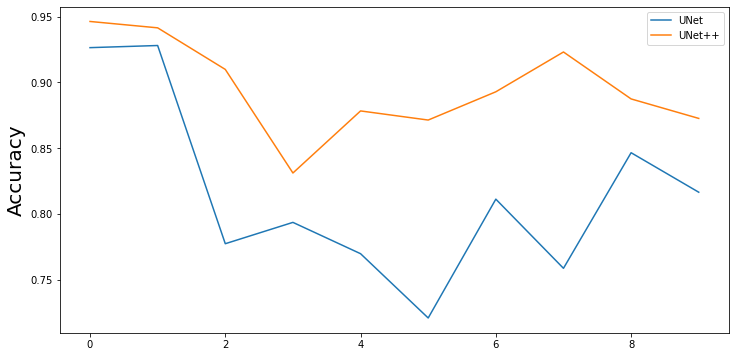

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(unet_iou, label='UNet')
plt.plot(unetpp_iou, label='UNet++')
plt.ylabel('Accuracy', size=20)
plt.legend()

- UNet++ 구조의 성능이 월등히 뛰어난 것을 확인할 수 있다.

## 회고록

- Semantic Segmentation은 label 이미지가 따로 있어서 그런지 전처리가 다른 CV 모델보다 복잡한 것 같다.
- UNet 구조는 pix2pix 프로젝트를 하면서 공부했었기 때문에 어렵지 않게 이해하고 넘어갈 수 있었다.
- 100 epoch 만으로도 생각보다 성능이 잘 나왔다.
- UNet은 어렵지 않았는데 UNet++의 구조는 처음 보는 구조여서 어떻게 구현해야 할지 막막했다. 그러나 쉬운 부분부터 하나씩 구현했더니 잘 구현된 것 같다.
- 원래라면 Loss Function도 바꿔줘야 하는데 너무 복잡해져서 우선 모델의 구조만 바꿔서 학습을 진행하였다.
- 학습 결과, UNet에서 UNet++ 로 구조만 바꿔주어도 충분히 성능이 향상된 것을 확인할 수 있었다.